In [86]:
from datetime import datetime

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import holidays
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

## Load Training and Testing Data

In [87]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_month", "post_day", "post_year", "days_since_previous_release",
         "release_post"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "month", "day"]])
del df["post_month"]
del df["day"]
del df["month"]
df

,year,days_since_previous_release,release_post,date
id,,,,
50,2016,NaN,False,2016-02-15
123,2016,NaN,False,2016-02-15
173,2016,NaN,False,2016-02-15
156,2016,NaN,False,2016-02-15
133,2016,NaN,False,2016-02-15
...,...,...,...,...
383,2023,8.0,True,2023-01-12
384,2023,5.0,True,2023-01-18
385,2023,5.0,True,2023-01-23


In [88]:
df.query("release_post == True & days_since_previous_release.isnull()")

,year,days_since_previous_release,release_post,date
id,,,,


In [89]:
df = df[df["days_since_previous_release"].notnull()].copy()

In [90]:
df = df[df["release_post"] == True].copy()

In [91]:
df = df[df["days_since_previous_release"] != 0].copy()

In [92]:
years = set(df["year"])
nj_holidays = holidays.UnitedStates(state="NJ", years=years)
nj_holidays.append({"{}-03-17".format(y) : "St. Patrick's Day" for y in years})
nj_holidays.append({"{}-02-14".format(y) : "Valentine's Day" for y in years})
del df["year"]

In [93]:
# Super Bowls count as holidays as far as beer is concerned lol
nj_holidays["2016-02-07"] = "Super Bowl 50"
nj_holidays["2017-02-05"] = "Super Bowl LI"
nj_holidays["2018-02-04"] = "Super Bowl LII"
nj_holidays["2019-02-03"] = "Super Bowl LIII"
nj_holidays["2020-02-02"] = "Super Bowl LIV"
nj_holidays["2021-02-07"] = "Super Bowl LV"
nj_holidays["2022-02-13"] = "Super Bowl LVI"
nj_holidays["2023-02-12"] = "Super Bowl LVII"

In [94]:
df = df.sort_values(by=["date"]).set_index("date")
daily = pandas.date_range(df.index.min(), df.index.max(), freq="D")
df = df.reindex(daily, method=None)
df["release_post"] = df["release_post"].fillna(False)

In [95]:
df = df.reset_index()
release_dates = list(df[df["release_post"] == True]["index"])
df["closest_release_date"] = df["index"].apply(lambda x : max([d for d in release_dates if d <= x]))
df["backfill"] = (df["index"] - df["closest_release_date"]).astype("timedelta64[D]")
df["days_since_previous_release"] = df["days_since_previous_release"].fillna(df["backfill"])
del df["backfill"]
del df["closest_release_date"]
df["future_release_date"] = df["index"].apply(lambda x : min([d for d in release_dates if d >= x]))
df["days_until_next_release"] = (df["future_release_date"] - df["index"]).astype("timedelta64[D]")
del df["future_release_date"]
df

,index,days_since_previous_release,release_post,days_until_next_release
0,2017-02-26,9.0,True,0.0
1,2017-02-27,1.0,False,19.0
2,2017-02-28,2.0,False,18.0
3,2017-03-01,3.0,False,17.0
4,2017-03-02,4.0,False,16.0
...,...,...,...,...
2162,2023-01-28,1.0,False,4.0
2163,2023-01-29,2.0,False,3.0
2164,2023-01-30,3.0,False,2.0
2165,2023-01-31,4.0,False,1.0


In [96]:
df["prob_of_release"] = (df["days_since_previous_release"] /
                         (df["days_since_previous_release"] + df["days_until_next_release"]))
del df["days_until_next_release"]

## Features

In [97]:
def get_features(df):
    # in addition to days_since_previous_release
    
    df["month_holidays"] = df["index"].apply(
        lambda x : len([h for h in nj_holidays if h.month == x.month and h.year == x.year]))
    
    df["weekday"] = df["index"].apply(lambda x : x.strftime("%A"))
    df["month"] = df["index"].apply(lambda x : x.strftime("%b"))
    
    df = pandas.get_dummies(df, columns=["weekday"], prefix="WD")
    df = pandas.get_dummies(df, columns=["month"], prefix="M")
    
    if "previous_release_post" not in df.columns:
        df["previous_release_post"] = df["release_post"].shift().fillna(False)
        df["previous_release_post"] = df["previous_release_post"].apply(int)
        del df["release_post"]
    
    return df

In [98]:
df = get_features(df)

<AxesSubplot: xlabel='prob_of_release', ylabel='Count'>

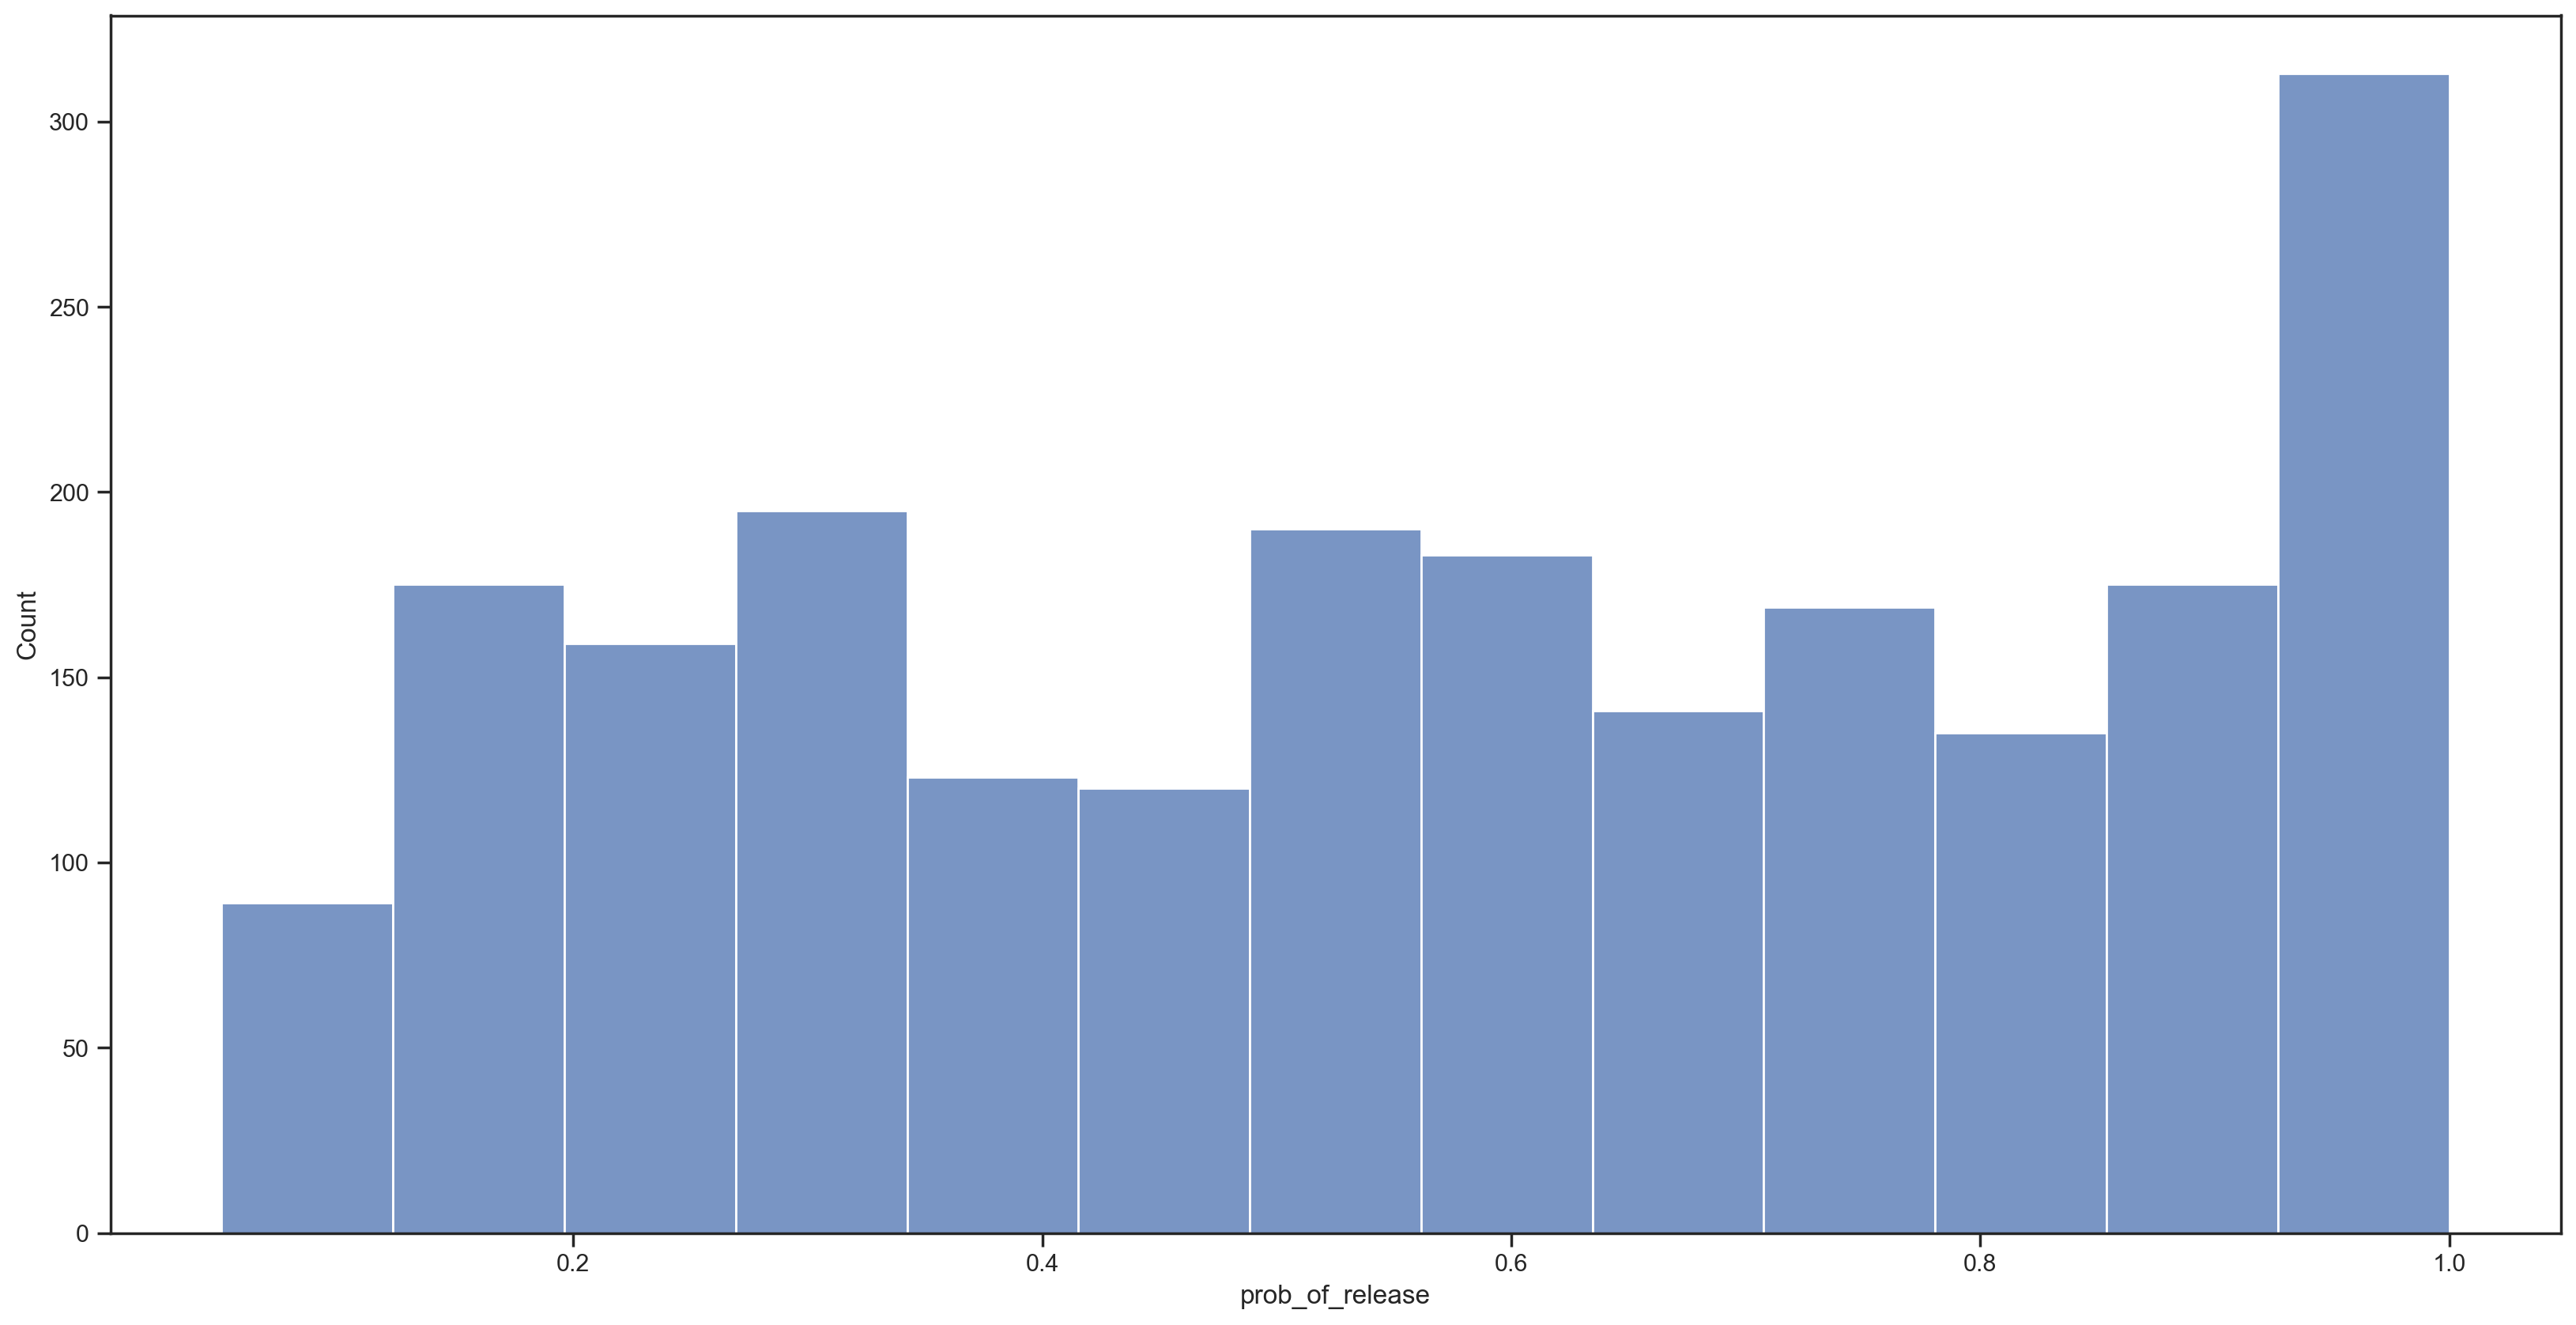

In [99]:
sns.histplot(x=df["prob_of_release"])

## Model-Building and Evaluation

In [100]:
train_df = df[0:int(len(df) * 0.90)].copy()
test_df = df[~df.index.isin(train_df.index)].copy()
print(len(train_df), len(test_df))

1950 217


In [101]:
features = [c for c in df.columns if c not in ["index", "prob_of_release", "release_post"]]
features

['days_since_previous_release',
 'month_holidays',
 'WD_Friday',
 'WD_Monday',
 'WD_Saturday',
 'WD_Sunday',
 'WD_Thursday',
 'WD_Tuesday',
 'WD_Wednesday',
 'M_Apr',
 'M_Aug',
 'M_Dec',
 'M_Feb',
 'M_Jan',
 'M_Jul',
 'M_Jun',
 'M_Mar',
 'M_May',
 'M_Nov',
 'M_Oct',
 'M_Sep',
 'previous_release_post']

In [102]:
scaler = StandardScaler()
scaler.fit(train_df[["days_since_previous_release", "month_holidays"]])
train_df[["days_since_previous_release", "month_holidays"]] = scaler.transform(
    train_df[["days_since_previous_release", "month_holidays"]])
test_df[["days_since_previous_release", "month_holidays"]] = scaler.transform(
    test_df[["days_since_previous_release", "month_holidays"]])

In [103]:
reg = ElasticNetCV(l1_ratio=[0.00001, 0.0001, 0.001, 0.1, .5, .7, .9, .95, .99, 1],
                   # scoring="neg_mean_absolute_percentage_error",
                   cv=3, random_state=1024)
reg.fit(train_df[features], train_df["prob_of_release"])

ElasticNetCV(cv=3,
             l1_ratio=[1e-05, 0.0001, 0.001, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             random_state=1024)

In [104]:
reg.l1_ratio_

1.0

In [105]:
reg.alpha_

0.002473857276004983

In [106]:
test_df["predicted"] = reg.predict(test_df[features])

In [107]:
mape(test_df["prob_of_release"], test_df["predicted"])

0.2807323361703682

<AxesSubplot: xlabel='predicted', ylabel='residuals'>

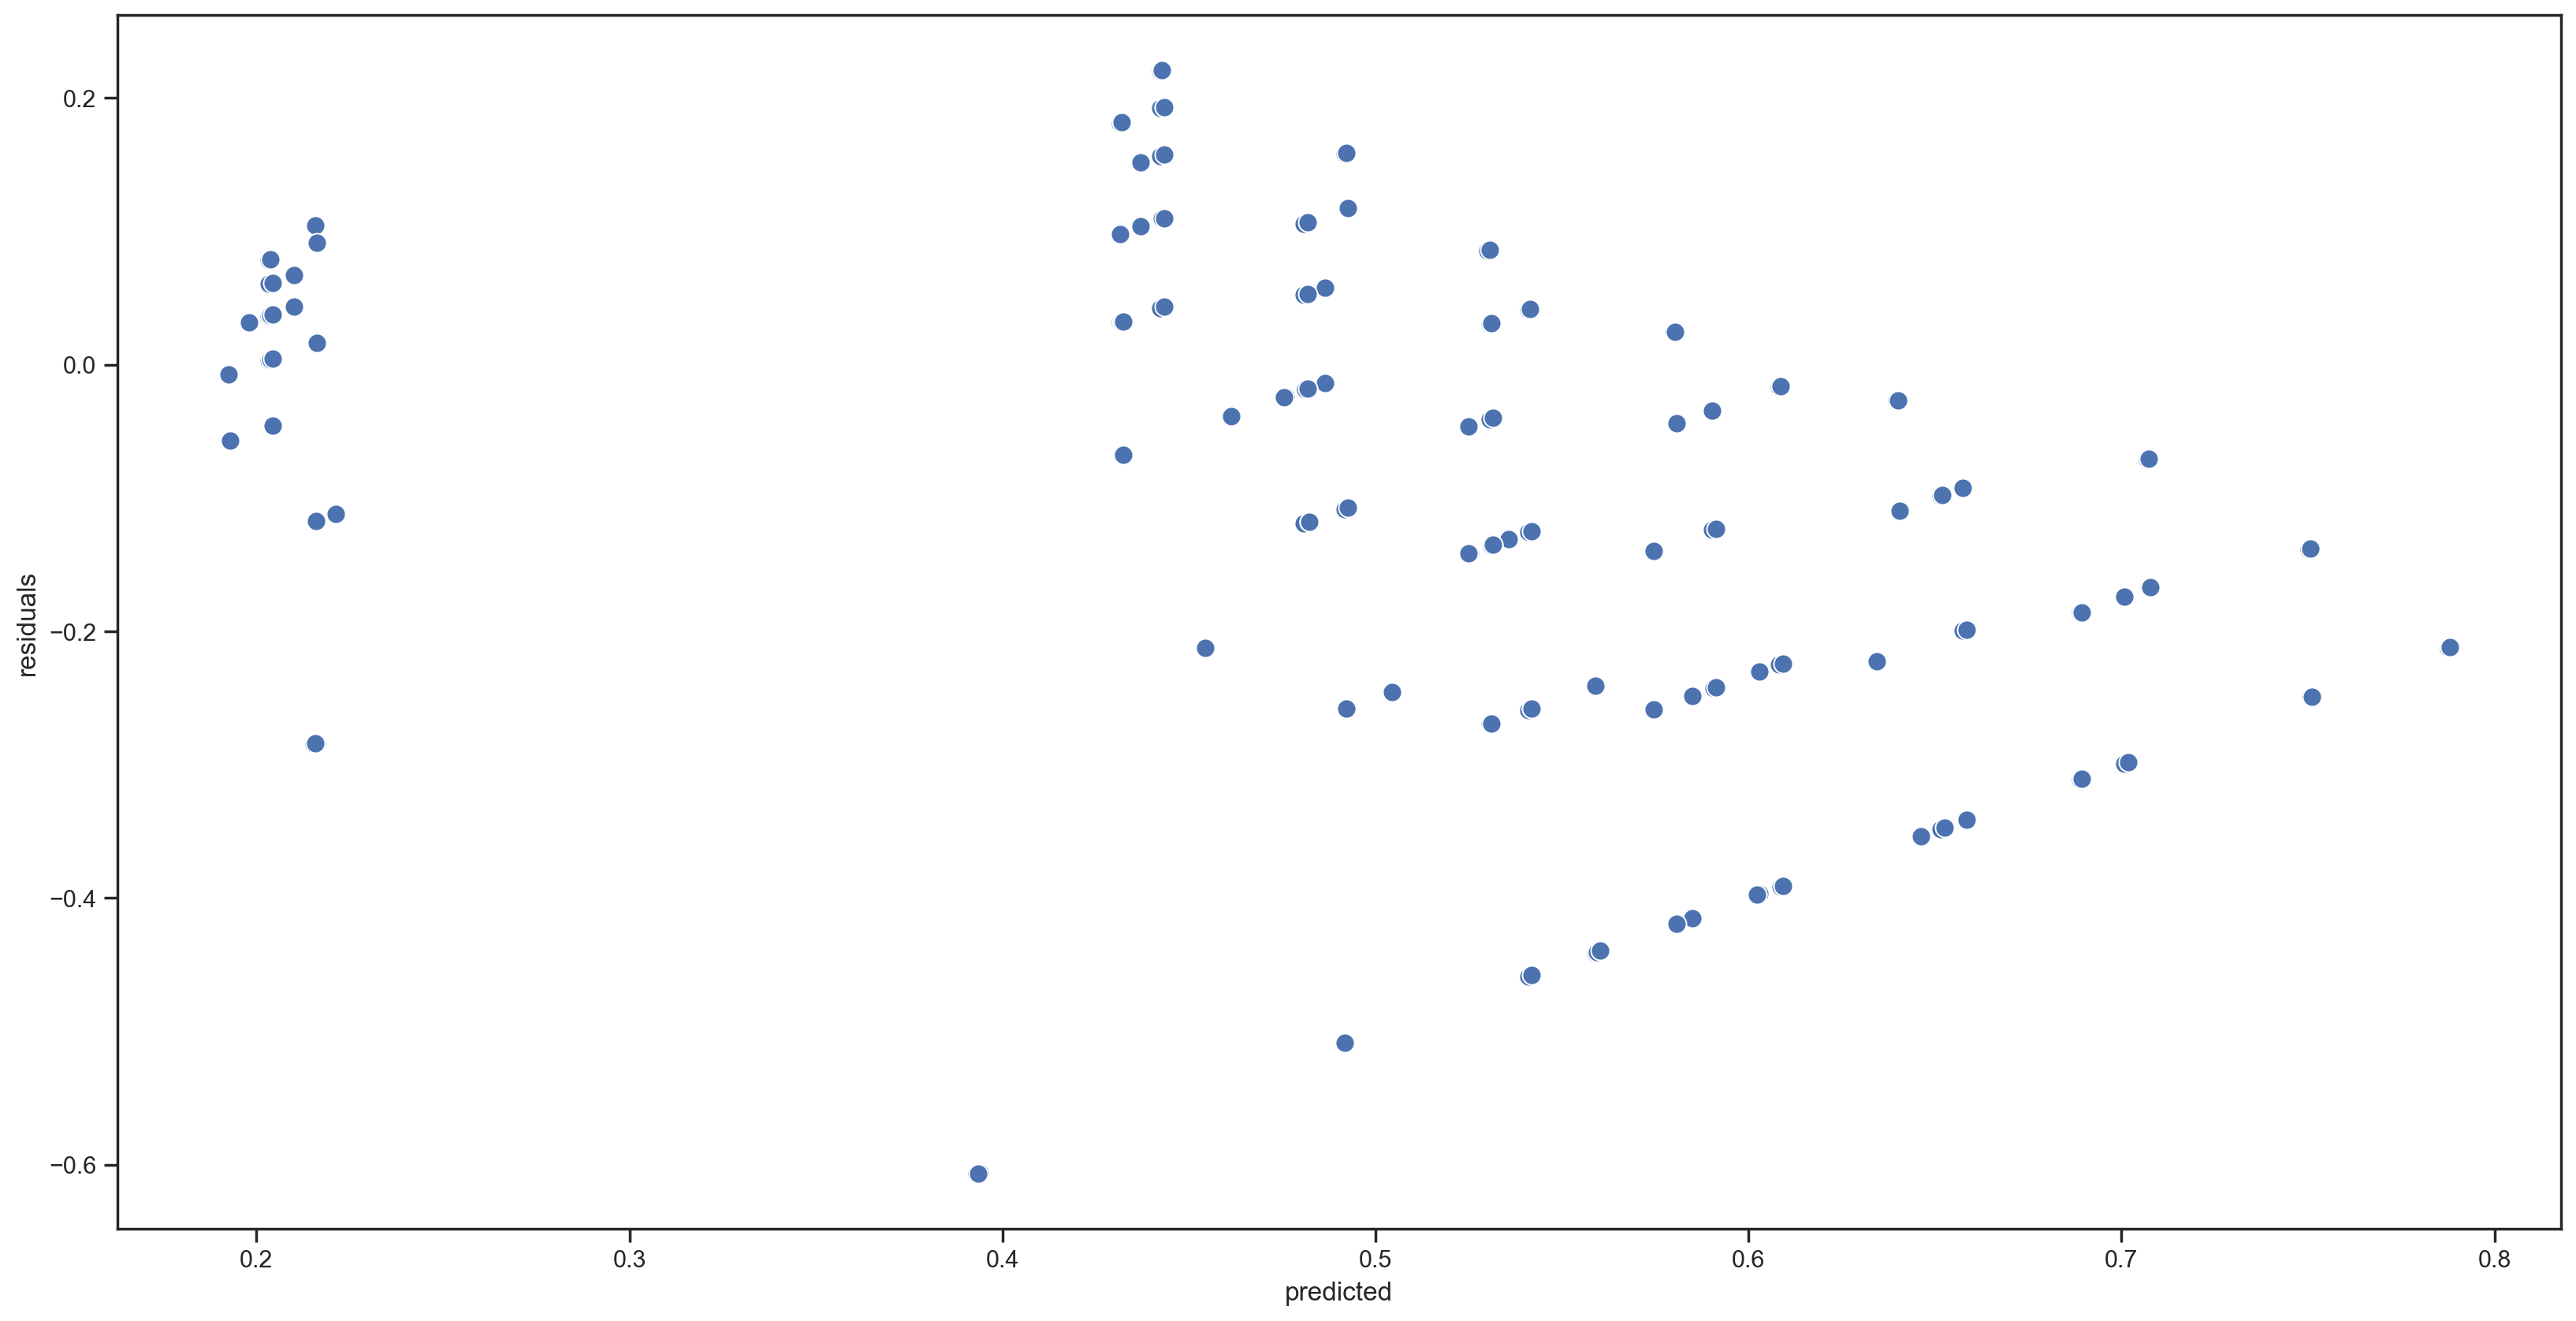

In [108]:
test_df["residuals"] = test_df["predicted"] - test_df["prob_of_release"]
sns.scatterplot(data=test_df, x="predicted", y="residuals", s=75)

In [109]:
sorted(zip(reg.feature_names_in_, reg.coef_), key=lambda x : x[1], reverse=True)

[('days_since_previous_release', 0.1676364249393147),
 ('WD_Wednesday', 0.017935756034461157),
 ('WD_Thursday', 0.01193522851697086),
 ('month_holidays', 0.0005342453559807456),
 ('WD_Friday', 0.0),
 ('WD_Saturday', -0.0),
 ('WD_Tuesday', 0.0),
 ('M_Apr', 0.0),
 ('M_Dec', -0.0),
 ('M_Feb', -0.0),
 ('M_Jan', 0.0),
 ('M_Jul', 0.0),
 ('M_Jun', 0.0),
 ('M_May', -0.0),
 ('M_Nov', 0.0),
 ('M_Oct', 0.0),
 ('M_Sep', 0.0),
 ('M_Aug', -0.0047868150517064376),
 ('WD_Monday', -0.010413030891062039),
 ('WD_Sunday', -0.01087510325594148),
 ('M_Mar', -0.017746992568288527),
 ('previous_release_post', -0.18971911080689283)]

In [110]:
test_df[["prob_of_release", "predicted", "residuals"]].sort_values(by=["residuals"])

,prob_of_release,predicted,residuals
1965,1.000000,0.393046,-0.606954
2112,1.000000,0.393519,-0.606481
2091,1.000000,0.393991,-0.606009
2028,1.000000,0.491672,-0.508328
2014,1.000000,0.491672,-0.508328
...,...,...,...
2064,0.250000,0.442359,0.192359
2098,0.250000,0.443304,0.193304
2140,0.250000,0.443304,0.193304
1951,0.222222,0.442359,0.220137


## Predictions for the Next Month

In [111]:
last_release_date = test_df[test_df["prob_of_release"] == 1][-1:].iloc[0]["index"]
next_week = pandas.DataFrame([{"index" : t} for t in 
                              pandas.date_range(start=last_release_date, freq="1D", periods=31)])
next_week = next_week[1:].copy()
next_week["days_since_previous_release"] = range(1, len(next_week) + 1)
next_week["previous_release_post"] = [1] + [0] * 29
next_week = get_features(next_week)

for f in features:
    if f not in next_week.columns:
        next_week[f] = 0
        
next_week[["days_since_previous_release", "month_holidays"]] = scaler.transform(
    next_week[["days_since_previous_release", "month_holidays"]])

In [112]:
next_week["predicted"] = reg.predict(next_week[features])

In [113]:
next_week[["index", "predicted"]]

,index,predicted
1,2023-02-02,0.216680
2,2023-02-03,0.443777
3,2023-02-04,0.493090
4,2023-02-05,0.531527
5,2023-02-06,0.581302
6,2023-02-07,0.641028
7,2023-02-08,0.708277
8,2023-02-09,0.751589
9,2023-02-10,0.788967
10,2023-02-11,0.838279
